## Demo Notebook to demonstrate process to run overturning calculation based on Argo float data

In [ ]:
import pathlib
import sys

script_dir = pathlib.Path().parent.absolute()
parent_dir = script_dir.parents[0]
sys.path.append(str(parent_dir))

import xarray as xr
from labsea_project import my_readers, writers, plotters, tools
import subprocess
import numpy as np

### 1 - Argo data loading and processing
First, we fetch Argo data within the Labradror Sea region form https://erddap.ifremer.fr year by year to avoid big files and crashes while loading, this takes some while. Next the data is merged and unnecessary data files are deleted

In [ ]:
# fetch argo data and save to 'data' directory
# this will take a while, so be patient
my_readers.fetch_argo_data_per_year()

In [ ]:

# Merge fetched agro data into one dataset along the profile dimension and delete individual yearly files to save space
data_dir = parent_dir / 'data'
files = sorted(data_dir.glob('ArgoFetched_*.nc'))
ds = xr.open_mfdataset(files, combine='nested', concat_dim='N_PROF', engine="netcdf4")
ds.to_netcdf(data_dir / 'LabSea_Argo_2004_2023.nc')

print("All files successfully merged and saved.")

for file in data_dir.glob('ArgoFetched_*.nc'):
    file.unlink()   

print("All individual yearly files have been deleted.")

Now we will process the data to select only profiles in range of 75km of the AR7W line
and save the result to a new file, delte the original file to save space.
The script will generate two nc files, one includes only profiles within 1000dbar isobars in the region, the other also includes some profiles on the shelf. It will aslo generate a plot of the profiles in the region to validate the script ran correctly.

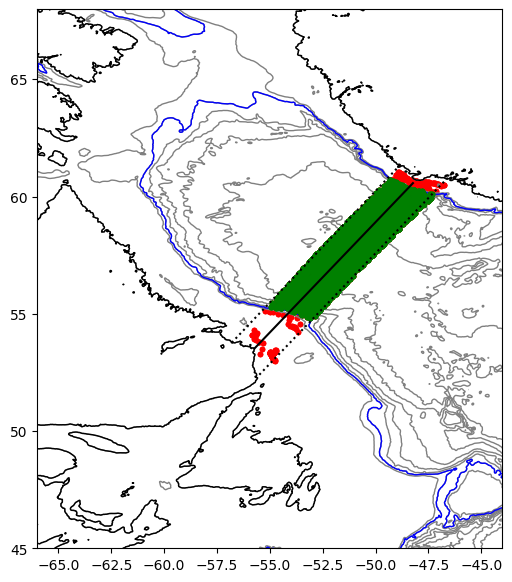

Argo data processing complete. Datasets saved.


In [3]:
script_path = f'{parent_dir}/scripts/argo_data_processing.py'
%run "{script_path}"

### 2 - Derive gridded composite sections

Now we calculate composite sections defining years and months argo data is selected for. For the demo, the months May, June and July are choosen for the decade between 2004 and 2013. First, masks are created for the specified cases and then weighted means are calculated with specified options, e.g the section start and end, the grid spacing and the parameter 'omega' which gives the width of the gaussian curve used for weighting in km. Gridded composites of sepcific volume anomaly, sigma0, SA and CT are saved automatically.

In [ ]:
# This function will select profiles and save a mask based on the specified season, and years,
# which is then used further to derive gridded sections for the selected case.

filename =  parent_dir / "data/argo_profiles_75kmAR7W_2004_to_2023_1000dB_isobars_filtered.nc"
case= '0413_mayjunjul'                                               # case string to identify the case
season = [5,6,7]                                                     # indicate months to select for the case
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013] # indicate years to select for the case
tools.select_profiles_and_save_masks(filename, case, season, years)

Mask saved to c:\Users\schul\OneDrive\Dokumente\Arbeit\Uni HH 2025\labsea-project\data\profile masks\mask_0413_mayjunjul.nc


This script computes a weighted mean of the specific volume anomaly, sigma0, SA and CT from selected profiles.
It can handle both Argo and CTD data, applying a Gaussian weighting based on the distance of profiles to grid points.
It will interpolate the profiles onto a common vertical grid and compute the weighted averages for each grid point.


In [ ]:
# Argo
case = '0413_mayjunjul'  # case string to identify the case
file_case = '2004_to_2023_1000db_isobars'

script_path = parent_dir / "scripts" / "calc_weighted_mean.py"
filename = parent_dir / "data" / f"argo_profiles_75kmAR7W_{file_case}.nc"
mask_profiles_file =  parent_dir / "data/profile masks" / f"mask_{case}.nc" # set to 'empty' if no mask should be used

# Optional arguments
spacing_z = 25
spacing_x = 10
omega = 30.0
xstart = 200
xend = 860

# make sure the output directory exists
output_dir = parent_dir / "data" / "weighted data"
output_dir.mkdir(parents=True, exist_ok=True)

output_file = parent_dir / "data/weighted data" / f"weighted_data_{file_case}_{case}_omega{int(omega)}_xstart{str(xstart)}_xend{xend}.npy"

python_executable = sys.executable

# Run the script
process_w = subprocess.Popen(
    [
        python_executable, str(script_path),
        str(filename),
        str(mask_profiles_file),
        str(output_file),
        
        "--spacing_z", str(spacing_z),
        "--spacing_x", str(spacing_x),
        "--omega", str(omega),
        "--xstart", str(xstart),
        "--xend", str(xend),
        "--argo"
    ],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
    encoding='utf-8'  
)

# Display output in real-time
for line in process_w.stdout:
    print(line, end="") 
    
# Display errors in real-time
for line in process_w.stderr:
    print(line, end="")

argo data is treated
c:\Users\schul\OneDrive\Dokumente\Arbeit\Uni HH 2025\labsea-project\data\argo_profiles_75kmAR7W_2004_to_2023_1000db_isobars.nc
Weighted data saved to c:\Users\schul\OneDrive\Dokumente\Arbeit\Uni HH 2025\labsea-project\data\weighted data\weighted_data_2004_to_2023_1000db_isobars_strong_spring_omega30_xstart200_xend860.npy

Processing Gridpoints: 100%|██████████| 67/67 [00:01<00:00, 37.82it/s]


### 3 - Derive overturning transports

In this following function a dataset is created loading all the relevant variables for the choosen case, and calculate the absolute geostrophical velocities and overturning transports, saved alltogether in a dataset. $\textcolor{blue}{mask\_sigma}$ is a boolean to decide whether values greater than $27.8 \hspace{0.1cm} kg/m^{3}$ should be excluded from the overturning calculations. Look at the function to see how the variables are derived in detail.

In [2]:
case = '0413_mayjunjul'
file_case = '2004_to_2023_1000db_isobars'
omega = 30.0
xstart = 200
xend = 860

Ds = writers.create_dataset(case, file_case, omega, xstart, xend, spacing_z=25, spacing_x=10, mask_sigma=True)

season: mayjunjul
cut_season: True


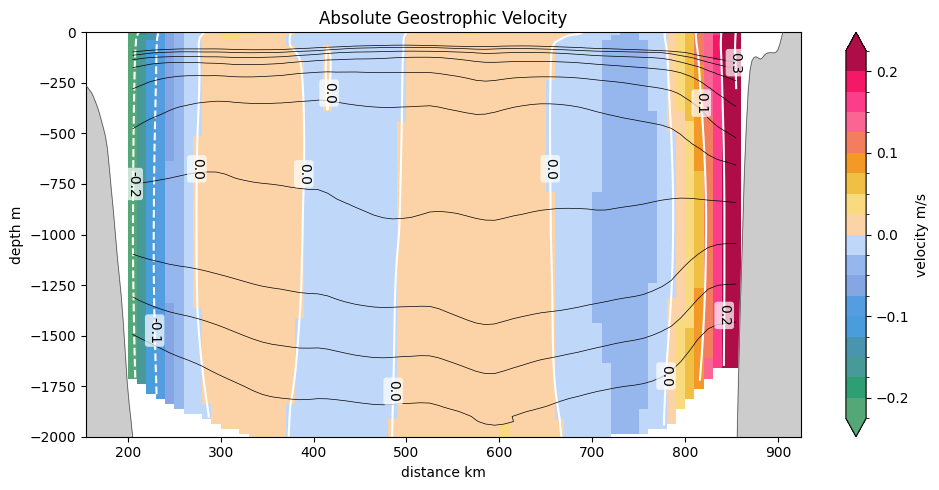

In [3]:
# Lets make some plots to visualize the data
''' Description of the plot:
This plot shows the absolute geostrophic velocity derived from Argo data.
black contours represent density contours in 0.02 kg/m^3 intervals.
white (labled) contours represent velocity contours in 0.1 m/s intervals.'''

plotters.plot_abs_geo_v(Ds, "Absolute Geostrophic Velocity", "xstart200_depth_space", saving=False)


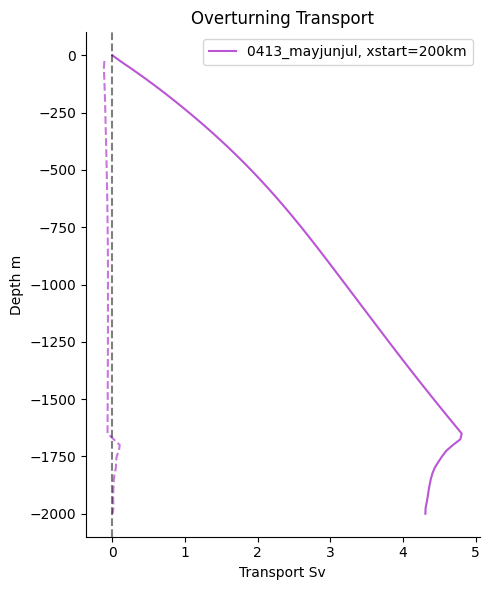

In [3]:
'''Description of the plot:
This plot shows the absolute geostrophic velocity derived from Argo data.
Dashed line represents pieceswise integrated transport, solid line represents cumulatively integrated transport.'''

plotters.plot_overturning_transport(
    Ds, 
    main_label=f"{case}, xstart={xstart}km", 
    main_color="mediumorchid",
    title="Overturning Transport",
    savepath=None
)

To make up for the imbalance in transport (we expect balanced transport for the Labrador Sea in this layer), we force the transport to be zero at 2000m depth by adding a constant velocity to the velocity section. There are two options, first the 'barotropic' option, which is a constant along the complete section and an adjustment only for the eastern 100km. For both, we derive the velocity satisfying the condition of balanced transport and adding it then in the process of deriving adjusted streamfunctions. For plotting purposes, we save them in seperate datasets.

In [4]:
# calc adujustment to balance transport in depth space
v = Ds['v'].values.copy()
xhalf = Ds['xhalf'].values
z = Ds['z'].values
sigma0half = Ds['sigma0half'].values.copy()

# barotropic adj.
c0 = tools.find_adjustment_velocity(v, xhalf*1e3, z*-1, onlyEast=False)
strf_z_adj0, strf_x_adj0, imbalance_adj0, mask_xa_adj0, pw_trapz_z0, pw_trapz_x_adj0 = tools.derive_strf(v, xhalf*1e3, z*-1, sensitivity=c0, onlyEast=False)
Ds['c0'] = c0

# declare new dataset to store the results
Ds_adj = xr.Dataset(
    {
        'v': (['z', 'xhalf'], v),
        'c0': c0,
        'strf_z': (['z'], strf_z_adj0),
        'strf_x': (['xhalf'], strf_x_adj0),
        'imbalance': imbalance_adj0,
        'mask_xa': (['xhalf'], mask_xa_adj0.data),
        'piecewise_trapz_z': (['z0'], pw_trapz_z0),
        'piecewise_trapz_x': (['x0'], pw_trapz_x_adj0)
    },
    coords={
        'xhalf': ('xhalf', xhalf),
        'z': ('z', z),
        'z0': ('z0', z[1:]),
        'x0': ('x0', xhalf[1:]),
    }
)

# adj. at eastern edge
c_east = tools.find_adjustment_velocity(v, xhalf*1e3, z*-1, onlyEast=True)
Ds['c_east'] = c_east

strf_z_adj_east, strf_x_adj_east, imbalance_adj_east, mask_xa_adj_east, pw_trapz_z_east, pw_trapz_x_adj_east = tools.derive_strf(v, xhalf*1e3, z*-1, sensitivity=c_east, onlyEast=True)


# Declare new dataset to store the results
Ds_adj_east = xr.Dataset(
    {
        'v': (['z', 'xhalf'], v),
        'c_east': c_east,
        'strf_z': (['z'], strf_z_adj_east),
        'strf_x': (['xhalf'], strf_x_adj_east),
        'imbalance': imbalance_adj_east,
        'mask_xa': (['xhalf'], mask_xa_adj_east.data),
        'piecewise_trapz_z': (['z0'], pw_trapz_z_east),
        'piecewise_trapz_x': (['x0'], pw_trapz_x_adj_east)
    },
    coords={
        'xhalf': ('xhalf', xhalf),
        'z': ('z', z),
        'z0': ('z0', z[1:]),
        'x0': ('x0', xhalf[1:]),
    }
)

Adjustment velocity of -0.003361 m/s determined at 4e-05 Sv vertical imbalance
Adjustment velocity of -0.02394 m/s determined at 0.000309 Sv vertical imbalance


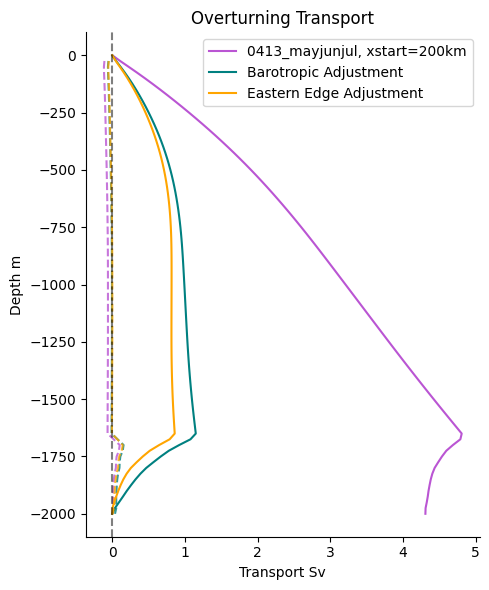

In [5]:
# plotting all together

plotters.plot_overturning_transport(
    Ds, 
    main_label=f"{case}, xstart={xstart}km", 
    main_color="mediumorchid",
    extra_lines=[
        {'ds': Ds_adj, 'label': 'Barotropic Adjustment', 'color': 'teal'},
        {'ds': Ds_adj_east, 'label': 'Eastern Edge Adjustment', 'color': 'orange'}
    ],
    title="Overturning Transport",
    savepath=None
)

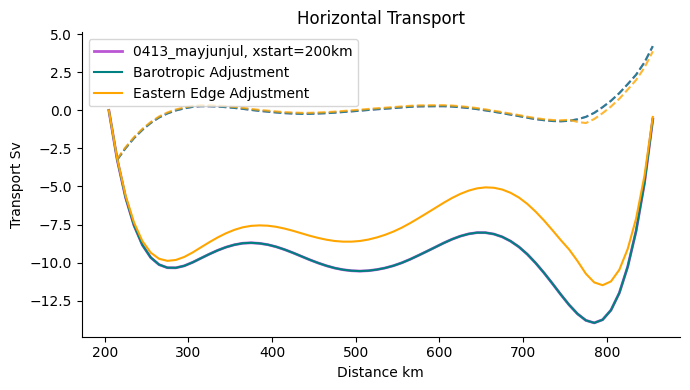

In [7]:
# horizontal transport plot

plotters.plot_horizontal_transport(
    Ds, 
    main_label=f"{case}, xstart={xstart}km", 
    main_color="mediumorchid",
    extra_lines=[
        {'ds': Ds_adj, 'label': 'Barotropic Adjustment', 'color': 'teal'},
        {'ds': Ds_adj_east, 'label': 'Eastern Edge Adjustment', 'color': 'orange'}
    ],
    title="Horizontal Transport",
    savepath=None)

#### Density space

To determine the transport in density space, we need a mean density depth to depth relation for the purpose of plotting the transport on a scaled depth. For this we will use all profiles available for the selected section. We first calculate composite sections accordingly, and then save the mean density of the section. Then the transport in density space is calculated and plotted

In [ ]:
# calculate scaled depth
file_case = '2004_to_2023_1000db_isobars'
case = 'all_data'
omega = 30.0
xstart = 200
xend = 860
spacing_z = 25
spacing_x = 10

script_path = parent_dir / "scripts" / "calc_weighted_mean.py"
filename = parent_dir / "data" / f"argo_profiles_75kmAR7W_{file_case}.nc"
mask_profiles_file =  'empty' # set to 'empty' if no mask should be used, aka all profiles should be used

output_file = parent_dir / "data/weighted data" / f"weighted_data_{file_case}_{case}_omega{int(omega)}_xstart{str(xstart)}_xend{xend}.npy"
python_executable = sys.executable

# Run the script
process_w = subprocess.Popen(
    [
        python_executable, str(script_path),
        str(filename),
        str(mask_profiles_file),
        str(output_file),
        
        "--spacing_z", str(spacing_z),
        "--spacing_x", str(spacing_x),
        "--omega", str(omega),
        "--xstart", str(xstart),
        "--xend", str(xend),
        "--argo"
    ],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
    encoding='utf-8'  
)

# Display output in real-time
for line in process_w.stdout:
    print(line, end="") 
    
# Display errors in real-time
for line in process_w.stderr:
    print(line, end="")

# load the saved data again and calculate/save the mean sigma0
specvol_anom_argo, sigma0_argo, SA_argo, CT_argo = np.load(parent_dir / f"data/weighted data/weighted_data_{file_case}_{case}_omega{int(omega)}_xstart{str(xstart)}_xend{xend}.npy")
mean_sigma0 = np.nanmean(sigma0_argo, axis=1)
np.save(parent_dir / f"data/mean_sigma0_{file_case}_{case}_omega{int(omega)}_xstart{str(xstart)}_xend{xend}.npy", mean_sigma0)

argo data is treated
c:\Users\schul\OneDrive\Dokumente\Arbeit\Uni HH 2025\labsea-project\data\argo_profiles_75kmAR7W_2004_to_2023_1000db_isobars.nc
Weighted data saved to c:\Users\schul\OneDrive\Dokumente\Arbeit\Uni HH 2025\labsea-project\data\weighted data\weighted_data_2004_to_2023_1000db_isobars_all_data_omega30_xstart200_xend860.npy

Processing Gridpoints: 100%|██████████| 67/67 [00:02<00:00, 24.76it/s]


In [ ]:
# load mean_sigma0 (not necessary if you just calculated it)
mean_sigma0 = np.load(parent_dir / f"data/mean_sigma0_{file_case}_all_data_omega{int(omega)}_xstart{str(xstart)}_xend{xend}.npy")

# derive transport in density space, define sigma_bins (griding of transport in density space / bins)
step = 0.005
sigma_bins = np.linspace(27.2, 27.8, np.int64((27.8-27.2)/step)+1)

# default: no adj.
Q0, Q = tools.derive_transport_in_density_space(v, sigma0half, sigma_bins)
Q0_adj, Q_adj = tools.derive_transport_in_density_space(v, sigma0half, sigma_bins, sensitivity=c0)    
Q0_east, Q_east = tools.derive_transport_in_density_space(v, sigma0half, sigma_bins, sensitivity=c_east, onlyEast=True)


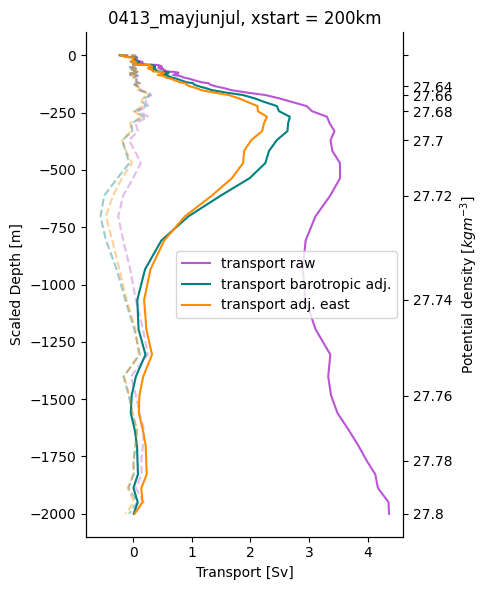

In [ ]:
# plot transport in density space

scaled_depth = np.interp(sigma_bins, mean_sigma0, z)
case = '0413_mayjunjul'

plotters.plot_density_space_transport(
    Q0, Q, scaled_depth,
    main_label="transport raw", main_color="mediumorchid",
    extra_lines=[
        {'Q': Q0_adj, 'Q_cum': Q_adj, 'label': 'transport barotropic adj.', 'color': 'teal'},
        {'Q': Q0_east, 'Q_cum': Q_east, 'label': 'transport adj. east', 'color': 'darkorange'}
    ],
    densities=[27.64, 27.66, 27.68, 27.7, 27.72, 27.74, 27.76, 27.78, 27.8],
    sigma_bins=sigma_bins, mean_sigma0=mean_sigma0, z=z,
    title=f"{case}, xstart = {xstart}km"
)